In [1]:
!pip install healpy

  Using cached healpy-1.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
Using cached healpy-1.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.9 MB)


In [15]:
import xarray as xr

xr.set_options(display_max_rows=27)
import fsspec
import numpy as np

url = "https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p175.nc"
fs = fsspec.filesystem("http")
ds = xr.open_dataset(fs.open(url), engine="h5netcdf")
print(ds)

<xarray.Dataset> Size: 119MB
Dimensions:               (along_track: 3854, cross_track: 298)
Coordinates:
  * along_track           (along_track) int64 31kB 0 1 2 3 ... 3851 3852 3853
  * cross_track           (cross_track) int64 2kB 0 1 2 3 4 ... 294 295 296 297
Data variables:
    sample_time           (along_track, cross_track) datetime64[ns] 9MB ...
    lat                   (along_track, cross_track) float32 5MB ...
    lon                   (along_track, cross_track) float32 5MB ...
    swath_blanking        (cross_track) bool 298B ...
    encoder_fore          (along_track, cross_track) float32 5MB ...
    encoder_aft           (along_track, cross_track) float32 5MB ...
    azimuth_fore          (along_track, cross_track) float32 5MB ...
    azimuth_aft           (along_track, cross_track) float32 5MB ...
    bearing               (along_track) float32 15kB ...
    u_model               (along_track, cross_track) float32 5MB ...
    v_model               (along_track, cross_trac

In [16]:

ds

<xarray.Dataset> Size: 119MB
Dimensions:               (along_track: 3854, cross_track: 298)
Coordinates:
  * along_track           (along_track) int64 31kB 0 1 2 3 ... 3851 3852 3853
  * cross_track           (cross_track) int64 2kB 0 1 2 3 4 ... 294 295 296 297
Data variables:
    sample_time           (along_track, cross_track) datetime64[ns] 9MB ...
    lat                   (along_track, cross_track) float32 5MB ...
    lon                   (along_track, cross_track) float32 5MB ...
    swath_blanking        (cross_track) bool 298B ...
    encoder_fore          (along_track, cross_track) float32 5MB ...
    encoder_aft           (along_track, cross_track) float32 5MB ...
    azimuth_fore          (along_track, cross_track) float32 5MB ...
    azimuth_aft           (along_track, cross_track) float32 5MB ...
    bearing               (along_track) float32 15kB ...
    u_model               (along_track, cross_track) float32 5MB ...
    v_model               (along_track, cross_track) float32 5MB ...
    ur_nonoise_fore       (along_track, cross_track) float32 5MB ...
    ur_nonoise_aft        (along_track, cross_track) float32 5MB ...
    radial_angle_fore     (along_track, cross_track) float32 5MB ...
    radial_angle_aft      (along_track, cross_track) float32 5MB ...
    ur_fore               (along_track, cross_track) float32 5MB ...
    ur_aft                (along_track, cross_track) float32 5MB ...
    wind_speed            (along_track, cross_track) float32 5MB ...
    wind_dir              (along_track, cross_track) float32 5MB ...
    ur_northward          (along_track, cross_track) float32 5MB ...
    ur_eastward           (along_track, cross_track) float32 5MB ...
    ur_nonoise_northward  (along_track, cross_track) float32 5MB ...
    ur_nonoise_eastward   (along_track, cross_track) float32 5MB ...
    ur_ac                 (along_track, cross_track) float32 5MB ...
    ur_al                 (along_track, cross_track) float32 5MB ...
    ur_nonoise_ac         (along_track, cross_track) float32 5MB ...
    ur_nonoise_al         (along_track, cross_track) float32 5MB ...
Attributes:
    title:                Odysea Simple Orbit Sampling V0.1
    project:              Odysea
    summary:              Simplified orbit sampling assuming basic Odysea orb...
    references:           Rodriguez 2018, Wineteer 2020
    institution:          Jet Propulsion Laboratory (JPL)
    creator_name:         Alexander Wineteer
    version_id:           0.1
    date_created:         2024-07-19 23:15:11.625266
    geospatial_lat_min:   -89.99N
    geospatial_lat_max:   89.99N
    geospatial_lon_min:   -180.00E
    geospatial_lon_max:   180.00E
    time_coverage_start:  2020-05-26 04:41:59.836864
    time_coverage_end:    2020-05-26 05:27:59.782619

In [17]:
import healpy as hp

In [86]:
class proj_odysea:
    
    def __init__(self,nside,multiscale=0):
        self.nside=nside
        self.multiscale=multiscale
        
    def eval(self,url_list):
        umap=None
        for url in url_list:
            print(url)
            fs = fsspec.filesystem("http")
            ds = xr.open_dataset(fs.open(url), engine="h5netcdf")
        
            mask = ~np.isnan(ds.u_model.data)
        
            hidx=hp.ang2pix(self.nside,ds.lon.values[mask],ds.lat.values[mask],lonlat=True,nest=True).flatten()

            if umap is None:
                umap  = np.bincount(hidx,weights=ds.u_model.values[mask].flatten(),minlength=12*nside**2)
                vmap  = np.bincount(hidx,weights=ds.v_model.values[mask].flatten(),minlength=12*nside**2)
                him   = np.bincount(hidx,minlength=12*nside**2)
            else:
                umap  += np.bincount(hidx,weights=ds.u_model.values[mask].flatten(),minlength=12*nside**2)
                vmap  += np.bincount(hidx,weights=ds.v_model.values[mask].flatten(),minlength=12*nside**2)
                him   += np.bincount(hidx,minlength=12*nside**2)
        
        umap[him>0]=umap[him>0]/him[him>0]
        vmap[him>0]=vmap[him>0]/him[him>0]

        umap[him==0]=hp.UNSEEN
        vmap[him==0]=hp.UNSEEN

        for k in range(self.multiscale):
            l_nside = self.nside//2**(k+1)
            l_scale = 4**(k++1)
            
            for url in url_list:
                print(url)
                fs = fsspec.filesystem("http")
                ds = xr.open_dataset(fs.open(url), engine="h5netcdf")
        
                mask = ~np.isnan(ds.u_model.data)
        
                hidx=hp.ang2pix(self.nside,ds.lon.values[mask],ds.lat.values[mask],lonlat=True,nest=True).flatten()
                l_umap=None
                if l_umap is None:
                    l_umap  = np.bincount(hidx,weights=ds.u_model.values[mask].flatten(),minlength=12*l_nside**2)
                    l_vmap  = np.bincount(hidx,weights=ds.v_model.values[mask].flatten(),minlength=12*l_nside**2)
                    him     = np.bincount(hidx,minlength=12*l_nside**2)
                else:
                    l_umap  += np.bincount(hidx,weights=ds.u_model.values[mask].flatten(),minlength=12*l_nside**2)
                    l_vmap  += np.bincount(hidx,weights=ds.v_model.values[mask].flatten(),minlength=12*l_nside**2)
                    him     += np.bincount(hidx,minlength=12*l_nside**2)

            l_umap[him>0]=l_umap[him>0]/him[him>0]
            l_vmap[him>0]=l_vmap[him>0]/him[him>0]
            l_idx=np.where(him>0)[0]
    
            l_idx=l_scale*np.repeat(l_idx,l_scale)+np.tile(np.arange(l_scale),l_idx.shape[0])
    
            idx=np.where(umap[l_idx]==hp.UNSEEN)[0]
    
            umap[l_idx[idx]]=l_umap[l_idx[idx]//(l_scale)]
            vmap[l_idx[idx]]=l_vmap[l_idx[idx]//(l_scale)]
        return umap,vmap
        
    def plot(self,u,v):
        plt.figure(figsize=(12,4))
        hp.cartview(u,nest=True,hold=False,sub=(1,2,1),title='U Model',min=-1,max=1,
                    unit=r'$m.s^{-1}$',cmap='jet',flip='geo')
        hp.cartview(v,nest=True,hold=False,sub=(1,2,2),title='V Model',min=-1,max=1,
                    unit=r'$m.s^{-1}$',cmap='jet',flip='geo')
        

In [82]:
pr=proj_odysea(256)

tab=["https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p%03d.nc"%(k) for k in range(161,180)]

u,v=pr.eval(tab)


https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p161.nc
https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p162.nc
https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p163.nc
https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p164.nc
https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p165.nc
https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p166.nc
https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p167.nc
https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p168.nc
https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_glob

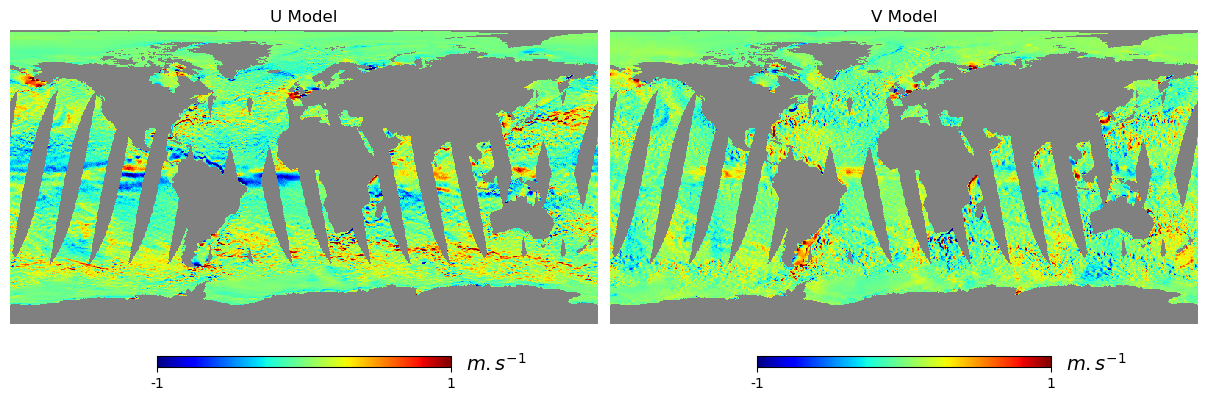

In [87]:
pr=proj_odysea(256)
pr.plot(u,v)

In [84]:
e,b=hp.map2alm_spin([u,v],spin=1)

/tmp/ipykernel_441/1587999325.py:2: RuntimeWarning: divide by zero encountered in divide
  hp.cartview(hp.alm2map(e,nside)/(u!=hp.UNSEEN),nest=True,hold=False,sub=(1,2,1),title='Divergence Model',unit=r'$m.s^{-1}$',cmap='jet',min=-1,max=1,flip='geo')
/tmp/ipykernel_441/1587999325.py:3: RuntimeWarning: divide by zero encountered in divide
  hp.cartview(hp.alm2map(b,nside)/(u!=hp.UNSEEN),nest=True,hold=False,sub=(1,2,2),title='Rotational Model',unit=r'$m.s^{-1}$',cmap='jet',min=-1,max=1,flip='geo')


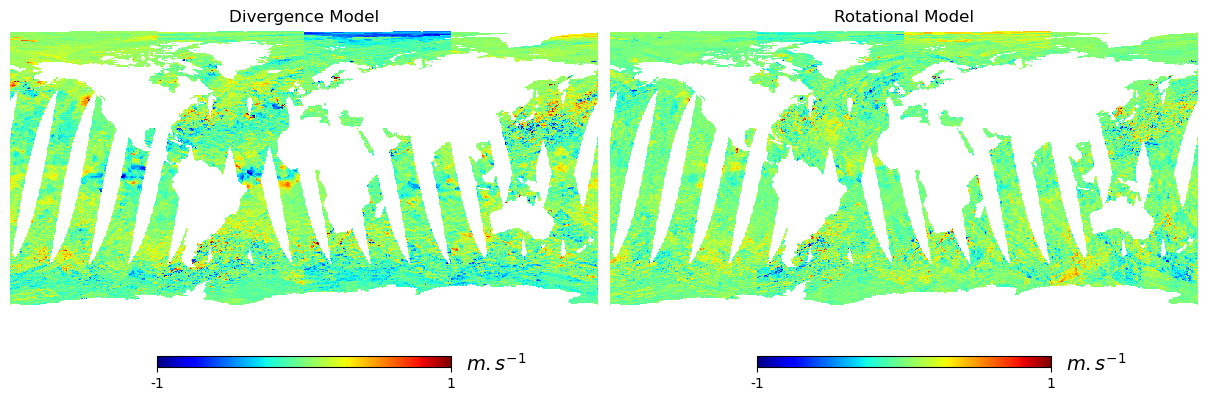

In [90]:
plt.figure(figsize=(12,4))
hp.cartview(hp.alm2map(e,nside)/(u!=hp.UNSEEN),nest=True,hold=False,sub=(1,2,1),title='Divergence Model',unit=r'$m.s^{-1}$',cmap='jet',min=-1,max=1,flip='geo')
hp.cartview(hp.alm2map(b,nside)/(u!=hp.UNSEEN),nest=True,hold=False,sub=(1,2,2),title='Rotational Model',unit=r'$m.s^{-1}$',cmap='jet',min=-1,max=1,flip='geo')

# Saving multilevel HEALPix Data in zarr and datatree 

In this notebook, we will demonstrate  examples of saving multilevel HEALPix data.  

## Setup

To run this notebook, you need to install XDGGS. You can find the xdggs repository here: [XDGGS GitHub Repository](https://github.com/xarray-contrib/xdggs.git).


1. You can either install `xdggs` with the necessary dependencies, use the following command:

```bash
pip install xdggs
```

2. You will need up to date xarray package :

```bash
pip install -U xarray
```

3. You can use zarr version zarr==2.18.4.  In a few weeks, it would work with icechunk as well. :

```bash
#pip install icechunk
pip install -U zarr==2.18.4
```


In [91]:
#!pip install xdggs pint_xarray icechunk
!pip install xdggs
#!pip install icechunk
!pip install -U zarr==2.18.4

  Using cached xdggs-0.1.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached cdshealpix-0.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached h3ronpy-0.22.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.8 kB)
  Using cached arro3_core-0.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (885 bytes)
Using cached xdggs-0.1.1-py3-none-any.whl (32 kB)
Using cached arro3_core-0.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
Using cached cdshealpix-0.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Using cached h3ronpy-0.22.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.4 MB)
  Attempting uninstall: zarr
    Found existing installation: zarr 2.18.2
    Uninstalling zarr-2.18.2:
      Successfully uninstalled zarr-2.18.2


In [92]:
import warnings

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xdggs

warnings.filterwarnings("ignore")

In [93]:
import zarr

zarr.__version__

'2.18.4'

In [99]:
level = 8
cell_ids = np.arange(12 * nside**2)
grid_info = {"grid_name": "healpix", "level": level, "indexing_scheme": "nested"}

ds_8 = (
    xr.Dataset(coords={"cell_ids": ("cells", cell_ids, grid_info)})
    .pipe(xdggs.decode)
    .pipe(lambda ds: ds.merge(ds.dggs.cell_centers()))
    .assign(
        data=lambda ds: np.cos(6 * np.radians(ds["latitude"]))
        * np.sin(6 * np.radians(ds["longitude"]))
    )
)
u_odyssea = xr.DataArray(
    u,dims=("cells"), coords={"cell_ids": ("cells", cell_ids, grid_info)}
)
ds_8["u_data"] = u_odyssea
u_odyssea = xr.DataArray(
    v,dims=("cells"), coords={"cell_ids": ("cells", cell_ids, grid_info)}
)
ds_8["v_data"] = v_odyssea
chunk_late = 12 * (4**2)
chunk_size_8 = int((ds_8.cells.size) / chunk_late)
print("chunk_size_8", chunk_size_8)
ds_8 = ds_8.chunk(chunks={"cells": chunk_size_8})
ds_8

NameError: name 'v_odyssea' is not defined

In [98]:
ds_8.to_zarr("u.zarr", mode="w")